## 逐步实现卷积神经网络

欢迎来到课程4的第一个作业！在此作业中，你将使用numpy实现卷积（CONV）和池化（POOL）层，包括正向传播和反向传播（可选）。

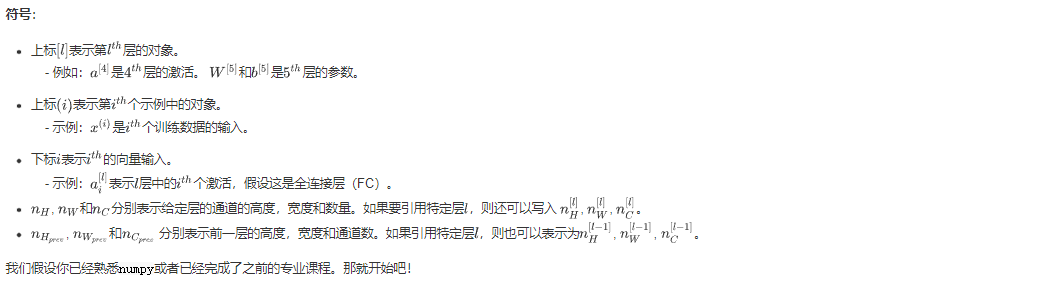



### 1 安装包
让我们首先导入在作业过程中需要用到的包：
- numpy 是Python科学计算的基本包。
- matplotlib 是在Python中常用的绘制图形的库。
- np.random.seed（1）使所有随机函数调用保持一致。这将帮助我们为你的作品评分。

In [2]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

### 2 作业大纲
你将实现构建卷积神经网络的需要的模块！要求实现的每个函数都有详细的说明，以帮助你完成所需的步骤：
- 卷积函数，包括：
    - 零填充
    - 卷积窗口
    - 正向卷积
    - 反向卷积（可选）
- 池化函数，包括：
    - 正向池化
    - 创建mask
    - 分配值
    - 反向池化（可选）
    
本笔记本将要求你使用 numpy从头开始实现这些函数。在下一本笔记本中，你将学习使用TensorFlow来实现：
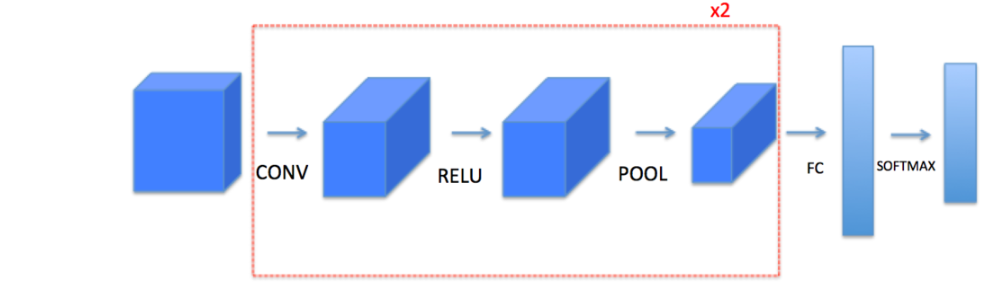

注意，对于每个正向函数，都有其对应的反向等式。因此，在正向传播模块的每一步中，都将一些参数存储在缓存中。这些参数用于在反向传播时计算梯度。

- 问问问：我记得层的顺序是 卷积 池化 relu激活，这里把relu放在中间层了，不知道可不可以

### 3 卷积神经网络
尽管编程框架可以方便使用卷积，但它们仍然是深度学习中最难理解的概念之一。卷积层将输入体积转换为不同大小的输出体积，如下所示。

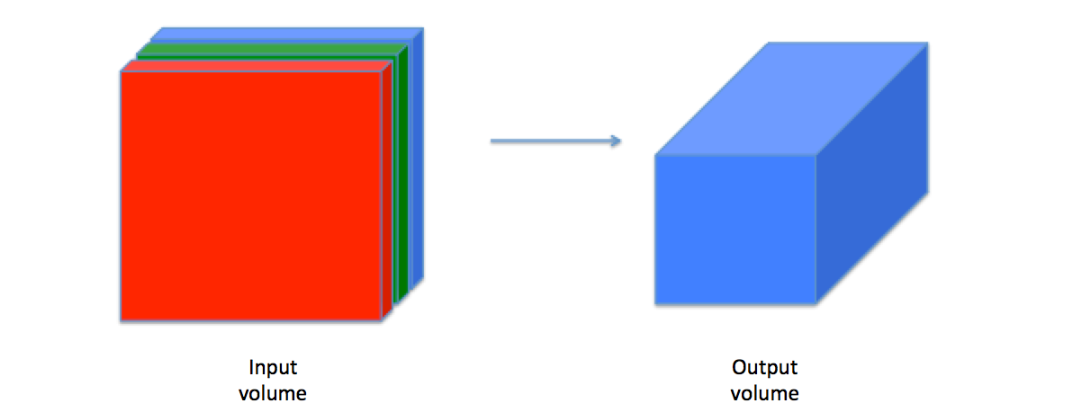

在这一部分，你将构建卷积层的每一步。首先实现两个辅助函数：一个用于零填充，另一个用于计算卷积函数本身。

#### 3.1 零填充
零填充将在图像的边界周围添加零：
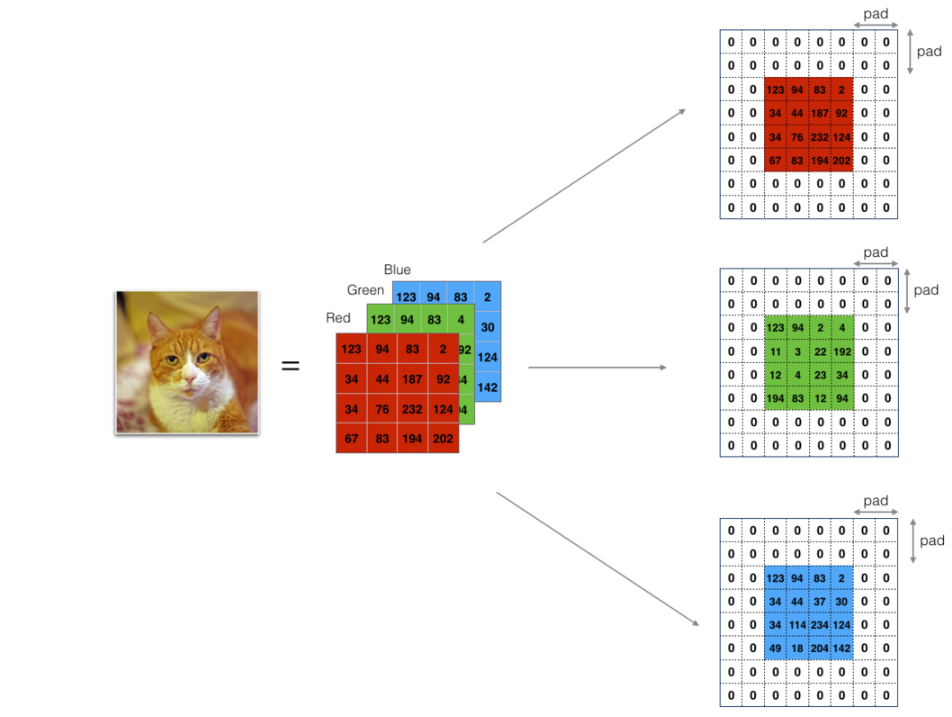
**图1 ：零填充**

图像（3个通道，RGB），填充2次。

填充的主要好处有：

- 允许使用CONV层而不必缩小其高度和宽度。这对于构建更深的网络很重要，因为高度/宽度会随着更深的层而缩小。一个重要、特殊的例子是"same"卷积，其中高度/宽度在一层之后被精确保留。
- 有助于我们将更多信息保留在图像边缘。如果不进行填充，下一层的一部分值将会受到图像边缘像素的干扰。

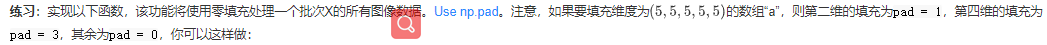

`a = np.pad(a, ((0,0), (1,1), (0,0), (3,3), (0,0)), 'constant', constant_values = (..,..))`

In [3]:
# GRADED FUNCTION: zero_pad

def zero_pad(X, pad):
    """
    Pad with zeros all images of the dataset X. The padding is applied to the height and width of an image, 
    as illustrated in Figure 1.
    
    Argument:
    X -- python numpy array of shape (m, n_H, n_W, n_C) representing a batch of m images
    pad -- integer, amount of padding around each image on vertical and horizontal dimensions
    
    Returns:
    X_pad -- padded image of shape (m, n_H + 2*pad, n_W + 2*pad, n_C)
    """
    
    ### START CODE HERE ### (≈ 1 line)
    X_pad = np.pad(X, ((0, 0),(pad, pad),(pad, pad),(0, 0)), 'constant', constant_values=0)
    ### END CODE HERE ###
    
    return X_pad

x.shape = (4, 3, 3, 2)
x_pad.shape = (4, 7, 7, 2)
x[1,1] = [[ 0.90085595 -0.68372786]
 [-0.12289023 -0.93576943]
 [-0.26788808  0.53035547]]
x_pad[1,1] = [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


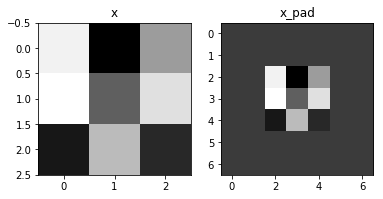

In [4]:
np.random.seed(1)
x = np.random.randn(4, 3, 3, 2)
x_pad = zero_pad(x, 2)
print ("x.shape =", x.shape)
print ("x_pad.shape =", x_pad.shape)
print ("x[1,1] =", x[1,1])
print ("x_pad[1,1] =", x_pad[1,1])

fig, axarr = plt.subplots(1, 2)
axarr[0].set_title('x')
axarr[0].imshow(x[0,:,:,0])
axarr[1].set_title('x_pad')
axarr[1].imshow(x_pad[0,:,:,0])

预期输出:

x.shape = (4, 3, 3, 2)

x_pad.shape = (4, 7, 7, 2)

x[1,1] = [[ 0.90085595 -0.68372786]
[-0.12289023 -0.93576943]
[-0.26788808 0.53035547]]

x_pad[1,1] = [[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]]

#### 3.2 卷积的单个步骤
在这一部分中，实现卷积的单个步骤，其中将滤波器（卷积核）应用于输入的单个位置。这将用于构建卷积单元，该卷积单元：
- 占用输入体积
- 在输入的每个位置都应用滤波器
- 输出另一个体积（通常大小不同）


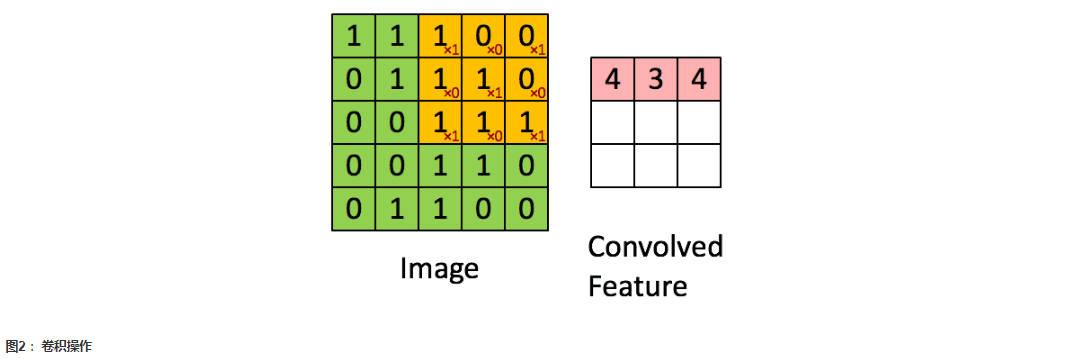

滤波器大小为2x2，步幅为1（步幅=每次滑动时移动窗口的数量）
- 我补充：虽然上图展示的滤波器尺寸是3，但是我们实现的滤波器尺寸是2

在计算机视觉应用中，左侧矩阵中的每个值都对应一个像素值，我们将3x3滤波器与图像进行卷积操作，首先将滤波器元素的值与原始矩阵相乘，然后将它们相加。在练习的第一步中，你将实现卷积的单个步骤，相当于仅对一个位置应用滤波器以获得单个实值输出。

在本笔记本的后面，你将应用此函数于输入的多个位置以实现完整的卷积运算。

**练习**：实现conv_single_step()。 提示.

In [5]:
# GRADED FUNCTION: conv_single_step

def conv_single_step(a_slice_prev, W, b):
    """
    Apply one filter defined by parameters W on a single slice (a_slice_prev) of the output activation 
    of the previous layer.
    
    Arguments:
    a_slice_prev -- slice of input data of shape (f, f, n_C_prev)
    W -- Weight parameters contained in a window - matrix of shape (f, f, n_C_prev)
    b -- Bias parameters contained in a window - matrix of shape (1, 1, 1)
    
    Returns:
    Z -- a scalar value, result of convolving the sliding window (W, b) on a slice x of the input data
    """

    ### START CODE HERE ### (≈ 2 lines of code)
    # Element-wise product between a_slice and W. Add bias.
    s = np.multiply(a_slice_prev, W) + b
    # Sum over all entries of the volume s
    Z = np.sum(s)
    ### END CODE HERE ###

    return Z

In [7]:
np.random.seed(1)
a_slice_prev = np.random.randn(4, 4, 3)
W = np.random.randn(4, 4, 3)
b = np.random.randn(1, 1, 1)

Z = conv_single_step(a_slice_prev, W, b)
print("Z =", Z)

Z = -23.16021220252078


**预期输出**:
Z = -23.16021220252078

#### 3.3 卷积神经网络--正向传递
在正向传递中，你将使用多个滤波器对输入进行卷积。每个“卷积”都会输出一个2D矩阵。然后，你将堆叠这些输出以获得3：
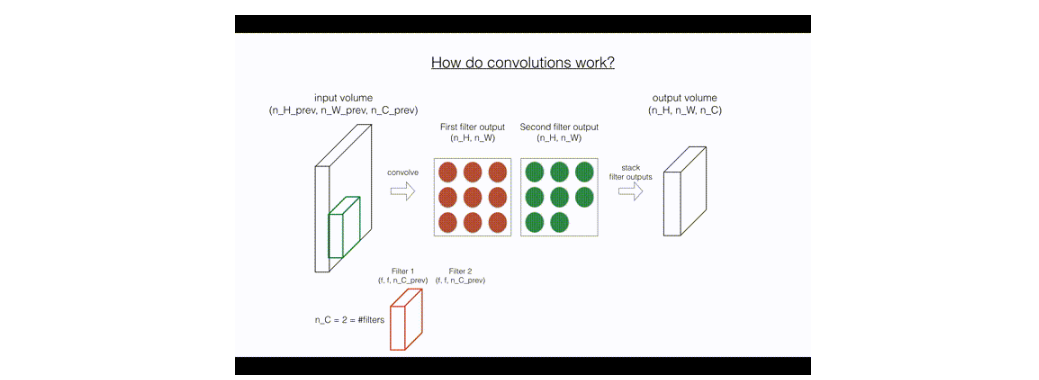

**练习**：实现以下函数，使用滤波器W卷积输入A_prev。此函数将上一层的激活输出（对于一批m个输入）A_prev作为输入，F表示滤波器/权重（W）和偏置向量（b），其中每个滤波器都有自己的（单个）偏置。最后，你还可以访问包含stride和padding的超参数字典。

**提示**：

1.要在矩阵“a_prev”（5,5,3）的左上角选择一个2x2切片，请执行以下操作：
'''
a_slice_prev = a_prev[0:2,0:2,:]
'''
使用定义的start/end索引定义a_slice_prev时将非常有用。

2.要定义a_slice，你需要首先定义其角点 vert_start, vert_end, horiz_start 和 horiz_end。该图可能有助于你找到如何在下面的代码中使用h，w，f和s定义每个角。

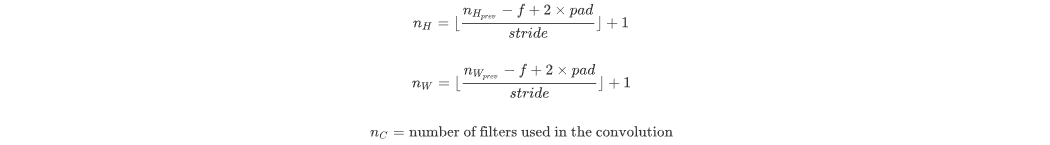
**图3 ：使用垂直和水平的start/end（2x2滤波器）定义切片**

该图仅显示一个通道。

**提醒：**

卷积的输出维度与输入维度相关公式为：
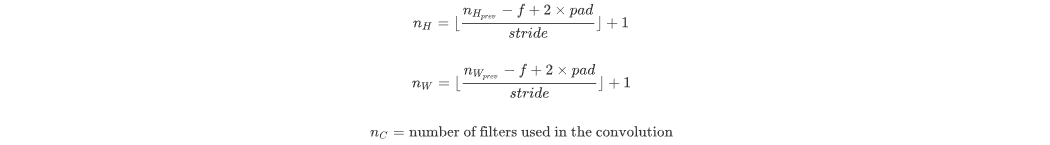

对于此作业，我们不必考虑向量化，只使用for循环实现所有函数。

In [8]:
# GRADED FUNCTION: conv_forward

def conv_forward(A_prev, W, b, hparameters):
    """
    Implements the forward propagation for a convolution function
    
    Arguments:
    A_prev -- output activations of the previous layer, numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    W -- Weights, numpy array of shape (f, f, n_C_prev, n_C)
    b -- Biases, numpy array of shape (1, 1, 1, n_C)
    hparameters -- python dictionary containing "stride" and "pad"
        
    Returns:
    Z -- conv output, numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache of values needed for the conv_backward() function
    """
    
    ### START CODE HERE ###
    # Retrieve dimensions from A_prev's shape (≈1 line)  
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # Retrieve dimensions from W's shape (≈1 line)
    (f, f, n_C_prev, n_C) = W.shape
    
    # Retrieve information from "hparameters" (≈2 lines)
    stride = hparameters['stride']
    pad = hparameters['pad']
    
    # Compute the dimensions of the CONV output volume using the formula given above. Hint: use int() to floor. (≈2 lines)
    n_H = 1 + int((n_H_prev + 2 * pad - f) / stride)
    n_W = 1 + int((n_W_prev + 2 * pad - f) / stride)
    
    # Initialize the output volume Z with zeros. (≈1 line)
    Z = np.zeros((m, n_H, n_W, n_C))
    
    # Create A_prev_pad by padding A_prev
    A_prev_pad = zero_pad(A_prev, pad)
    
    for i in range(m):                               # loop over the batch of training examples
        a_prev_pad = A_prev_pad[i]                               # Select ith training example's padded activation
        for h in range(n_H):                           # loop over vertical axis of the output volume
            for w in range(n_W):                       # loop over horizontal axis of the output volume
                for c in range(n_C):                   # loop over channels (= #filters) of the output volume
                    
                    # Find the corners of the current "slice" (≈4 lines)
                    vert_start = h * stride
                    vert_end = vert_start + f
                    horiz_start = w * stride
                    horiz_end = horiz_start + f
                    
                    # Use the corners to define the (3D) slice of a_prev_pad (See Hint above the cell). (≈1 line)
                    a_slice_prev = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :]
                  
                    # Convolve the (3D) slice with the correct filter W and bias b, to get back one output neuron. (≈1 line)
                    Z[i, h, w, c] = np.sum(np.multiply(a_slice_prev, W[:, :, :, c]) + b[:, :, :, c])
                                        
    ### END CODE HERE ###
    
    # Making sure your output shape is correct
    assert(Z.shape == (m, n_H, n_W, n_C))
    
    # Save information in "cache" for the backprop
    cache = (A_prev, W, b, hparameters)
    
    return Z, cache

In [9]:
np.random.seed(1)
A_prev = np.random.randn(10,4,4,3)
W = np.random.randn(2,2,3,8)
b = np.random.randn(1,1,1,8)
hparameters = {"pad" : 2,
               "stride": 1}

Z, cache_conv = conv_forward(A_prev, W, b, hparameters)
print("Z's mean =", np.mean(Z))
print("cache_conv[0][1][2][3] =", cache_conv[0][1][2][3])

Z's mean = 0.15585932488906465
cache_conv[0][1][2][3] = [-0.20075807  0.18656139  0.41005165]


**预期输出**:

Z's mean = 0.15585932488906465

cache_conv[0][1][2][3] = [-0.20075807 0.18656139 0.41005165]

最后，CONV层还应包含一个激活，此情况下，我们将添加以下代码行：
```python
# Convolve the window to get back one output neuron  
Z[i, h, w, c] = ...  
# Apply activation  
A[i, h, w, c] = activation(Z[i, h, w, c])
```
在这里你不需要做这个。

### 4 池化层

池化（POOL）层减少了输入的高度和宽度。它有助于减少计算量，而且可以使特征检测器在输入中的位置保持不变。池化层有两种：
- 最大池化：在输入上滑动 (f,f)窗口，并将窗口的最大值存储在输出中。
- 平均池化：在输入上滑动 (f,f)窗口，并将该窗口的平均值存储在输出中。
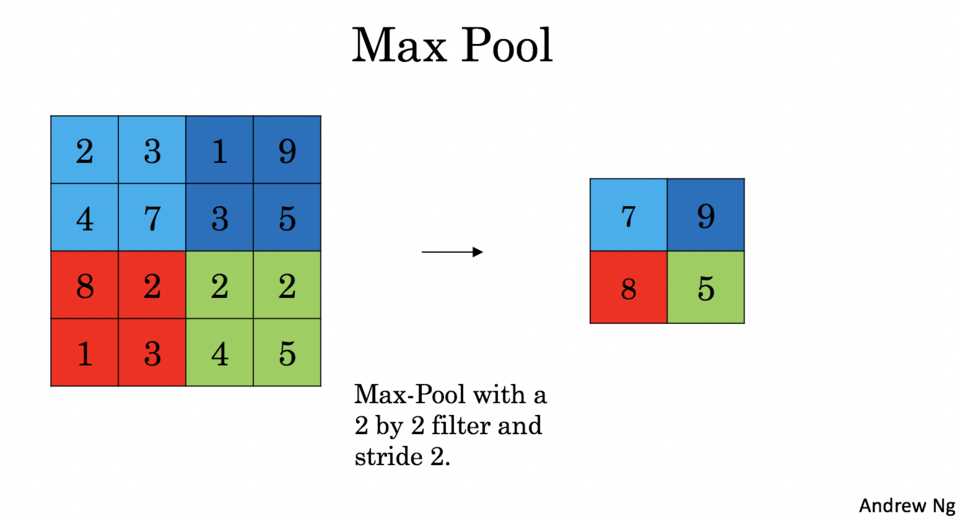


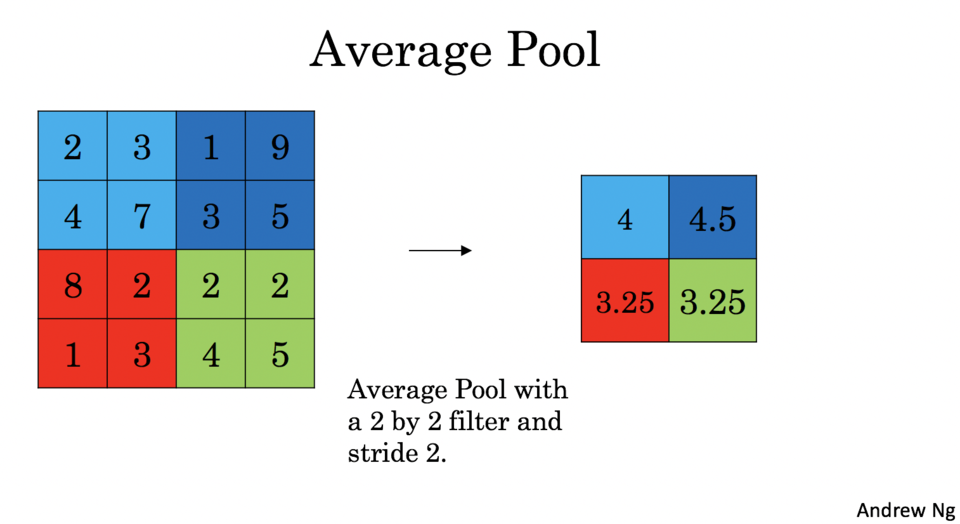

这些池化层没有用于反向传播训练的参数。但是，它们具有超参数，例如窗口大小f，它指定了你要计算最大值或平均值的窗口的高度和宽度。

#### 4.1 正向池化
现在，你将在同一函数中实现最大池化和平均池化。

**练习**：实现池化层的正向传播。请遵循下述提示。

**提示**：
由于没有填充，因此将池化的输出维度绑定到输入维度的公式为：
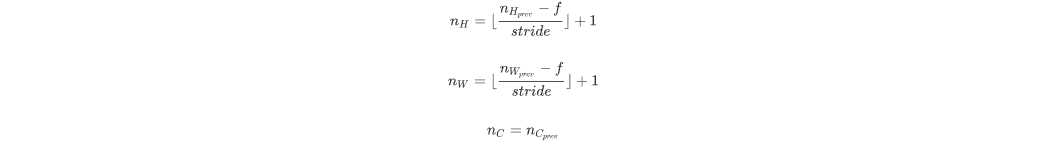

In [3]:
# GRADED FUNCTION: pool_forward

def pool_forward(A_prev, hparameters, mode = "max"):
    """
    Implements the forward pass of the pooling layer
    
    Arguments:
    A_prev -- Input data, numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    hparameters -- python dictionary containing "f" and "stride"
    mode -- the pooling mode you would like to use, defined as a string ("max" or "average")
    
    Returns:
    A -- output of the pool layer, a numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache used in the backward pass of the pooling layer, contains the input and hparameters 
    """
    
    # Retrieve dimensions from the input shape
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # Retrieve hyperparameters from "hparameters"
    f = hparameters["f"]
    stride = hparameters["stride"]
    
    # Define the dimensions of the output
    n_H = int(1 + (n_H_prev - f) / stride)
    n_W = int(1 + (n_W_prev - f) / stride)
    n_C = n_C_prev
    
    # Initialize output matrix A
    A = np.zeros((m, n_H, n_W, n_C))              
    
    ### START CODE HERE ###
    for i in range(m):                         # loop over the training examples
        for h in range(n_H):                     # loop on the vertical axis of the output volume
            for w in range(n_W):                 # loop on the horizontal axis of the output volume
                for c in range (n_C):            # loop over the channels of the output volume
                    
                    # Find the corners of the current "slice" (≈4 lines)
                    vert_start = h * stride
                    vert_end = vert_start + f
                    horiz_start = w * stride
                    horiz_end = horiz_start + f
                    
                    # Use the corners to define the current slice on the ith training example of A_prev, channel c. (≈1 line)
                    a_prev_slice = A_prev[i, vert_start:vert_end, horiz_start:horiz_end, c]
                    
                    # Compute the pooling operation on the slice. Use an if statment to differentiate the modes. Use np.max/np.mean.
                    if mode == "max":
                        A[i, h, w, c] = np.max(a_prev_slice)
                    elif mode == "average":
                        A[i, h, w, c] = np.mean(a_prev_slice)
    
    ### END CODE HERE ###
    
    # Store the input and hparameters in "cache" for pool_backward()
    cache = (A_prev, hparameters)
    
    # Making sure your output shape is correct
    assert(A.shape == (m, n_H, n_W, n_C))
    
    return A, cache


In [4]:
np.random.seed(1)
A_prev = np.random.randn(2, 4, 4, 3)
hparameters = {"stride" : 1, "f": 4}

A, cache = pool_forward(A_prev, hparameters)
print("mode = max")
print("A =", A)
print()
A, cache = pool_forward(A_prev, hparameters, mode = "average")
print("mode = average")
print("A =", A)

mode = max
A = [[[[1.74481176 1.6924546  2.10025514]]]


 [[[1.19891788 1.51981682 2.18557541]]]]

mode = average
A = [[[[-0.09498456  0.11180064 -0.14263511]]]


 [[[-0.09525108  0.28325018  0.33035185]]]]


预期输出:
mode = max

A = [[[[1.74481176 1.6924546 2.10025514]]]

[[[1.19891788 1.51981682 2.18557541]]]]

mode = average

A = [[[[-0.09498456 0.11180064 -0.14263511]]]

[[[-0.09525108 0.28325018 0.33035185]]]]


Nice！现在你已经实现了卷积网络所有层的正向传播。

笔记本的其余部分是可选择学习的，不会用于评分。

### 5 卷积神经网络中的反向传播（可选练习）

略